# Vanilla Cross Entropy Training

In [1]:
# Install necessary libraries
!pip install -q fastai seaborn wandb

In [2]:
# Enable autoreload of code from imported files
%reload_ext autoreload
%autoreload 2

In [3]:
# Get all the necessary imports
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb, datetime
plt.style.use("fivethirtyeight")
import seaborn as sns

In [4]:
# # Start a new project in wandb
wandb.init(project = "oxford_flowers_classification")
wandb.run.name = "VanillaCrossEntropy"

wandb: Currently logged in as: vinayak_nayak. Use `wandb login --relogin` to force relogin


# Define Dataloading portion

In [5]:
# Read the data file containing input output pairs and the datapoint class
df = pd.read_csv("../data/data.csv")

In [6]:
# Define getter for input ImageBlock
def get_x(row): 
    return f'../data/oxford-102-flowers/{row["ImgPath"]}'

# Define getter for output CategoryBlock
def get_y(row): 
    return row["ImgLabel"] 

# Define trian validation splitter
def splitter(df):
    train_idxs = df[df.SetType == "train"].index.tolist()
    valid_idxs = df[df.SetType == "valid"].index.tolist()
    return (train_idxs, valid_idxs)

# Define CPU based item transforms here
def get_item_tfms(size):
    return Resize(size, pad_mode = PadMode.Zeros, method = ResizeMethod.Pad)()

# Define GPU based augmentation transforms here
def get_aug_tfms():
    proba = 0.3
    h = Hue(max_hue = 0.3, p = proba, draw=None, batch=False)
    s = Saturation(max_lighting = 0.3, p = proba, draw=None, batch=False)
    ag_tfms = aug_transforms(mult = 1.00, do_flip = True, flip_vert = False, max_rotate = 5, 
                            min_zoom = 0.9, max_zoom = 1.1, max_lighting = 0.5, max_warp = 
                            0.05, p_affine = proba, p_lighting = proba, xtra_tfms = [h, s], 
                            size = 224, mode = 'bilinear', pad_mode = "zeros", align_corners = True, 
                            batch = False, min_scale = 0.75)
    return ag_tfms

# Define a function to retrieve the dataloader
# Use the subordinate functions defined above for the same
def get_dls(df):
    BATCH_SIZE = 16
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          get_x = get_x,
                          get_y = get_y,
                          splitter = splitter,
                          item_tfms = Resize(size = 460),
                          batch_tfms = get_aug_tfms())

    dls = datablock.dataloaders(source=df, bs = BATCH_SIZE, drop_last = True)
    return dls

# Standard Training with CrossEntropy Loss

In [7]:
# Define evaluation metrics for test set and add them to the learner so
# We can check the progress during every epoch

from functools import lru_cache

# Define a function to get true values and predictions for test set
@lru_cache
def get_test_fvs(x, y):
    # Input here doesn't matter since we will be receiving validation predictions and ground truth
    # But we need to predict on test dataset, so we need to do a forward pass on test images, 
    # extract those predictions and then get a comparison of the 
    # Get the test dataset
    test_df = df[df.SetType == "test"].reset_index(drop = True)
    test_dls = learn.dls.test_dl(test_df.ImgPath.apply(lambda x: f"../data/oxford-102-flowers/{x}").tolist(), drop_last = False)
    true_values = TensorBase([list(dls.vocab).index(x) for x in test_df.ImgLabel.tolist()])
    
    preds = []
    with torch.no_grad():
        for xb, in test_dls:
            preds.append(learn.model(xb).cpu())
    preds = torch.cat(preds)
    predictions = preds.argmax(dim = -1)
    return (true_values, predictions)

# Using the method above, define a function for computation of accuracy
def testAccuracy(x, y):
    start = time.time()
    true_values, predictions = get_test_fvs(x.cpu(), y.cpu())
    return ((true_values == predictions) * 1.0).mean()

# Using the method above, define a function for computation of accuracy
def testF1Score(x, y):
    start = time.time()
    true_values, predictions = get_test_fvs(x.cpu(), y.cpu())
    return F1Score(average = "macro")(true_values, predictions)

# Wrap the testset metric functions around AccumMetric
test_acc = AccumMetric(testAccuracy, dim_argmax = -1)
test_f1 = AccumMetric(testF1Score, dim_argmax = -1)

In [8]:
dls = get_dls(df)
print(f"Train Batches: {len(dls.train):>8}", f"Validation Batches: {len(dls.valid):>3}", sep = "\n")
learn = vision_learner(dls, resnet50, metrics = [accuracy, F1Score(average="macro"), test_acc, test_f1])

Train Batches:       63
Validation Batches:  64


SuggestedLRs(valley=0.001737800776027143)

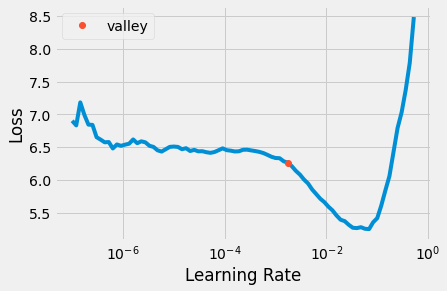

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,testAccuracy,testF1Score,time
0,5.545719,2.873401,0.362745,0.327686,0.310294,0.273931,00:47
1,3.324210,1.180068,0.716667,0.706609,0.683851,0.658431,00:46
2,1.940944,0.807333,0.809804,0.803683,0.785006,0.769061,00:47
3,1.219779,0.673838,0.827451,0.824011,0.805659,0.790069,00:47
4,0.756905,0.564786,0.859804,0.856552,0.838348,0.825356,00:47
5,0.561811,0.509139,0.874510,0.873743,0.852171,0.842991,00:46
6,0.400161,0.491945,0.879412,0.878334,0.856725,0.847370,00:47
7,0.367430,0.489805,0.877451,0.876371,0.856074,0.847760,00:47


Better model found at epoch 0 with valid_loss value: 2.873401165008545.


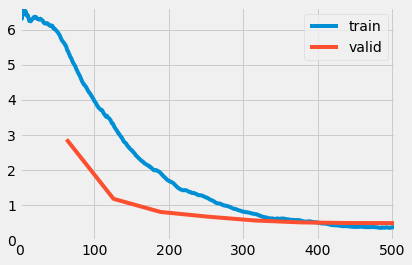

Better model found at epoch 1 with valid_loss value: 1.180068016052246.
Better model found at epoch 2 with valid_loss value: 0.8073331117630005.
Better model found at epoch 3 with valid_loss value: 0.6738378405570984.
Better model found at epoch 4 with valid_loss value: 0.5647860765457153.
Better model found at epoch 5 with valid_loss value: 0.5091386437416077.
Better model found at epoch 6 with valid_loss value: 0.4919445812702179.
Better model found at epoch 7 with valid_loss value: 0.48980486392974854.


In [10]:
learn.fit_one_cycle(8, lr_max = 1.7e-3, cbs = [WandbCallback(n_preds = 10),
                                               SaveModelCallback(fname = "../models/ce_frozen_model"), 
                                               CSVLogger(fname = "../logs/ce_frozen_loss.csv"),
                                               ShowGraphCallback()])

SuggestedLRs(valley=0.00010964782268274575)

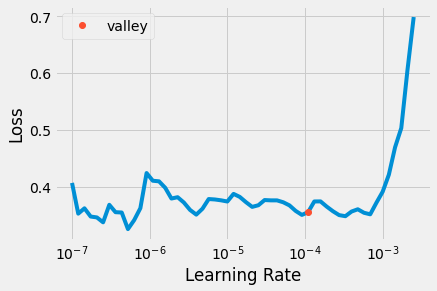

In [11]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,testAccuracy,testF1Score,time
0,0.358684,0.470372,0.880392,0.877894,0.861603,0.852652,00:48
1,0.335384,0.466116,0.877451,0.875029,0.859652,0.847122,00:49
2,0.355423,0.565953,0.861765,0.858792,0.828265,0.817404,00:49
3,0.433215,0.614693,0.837255,0.836082,0.814441,0.805639,00:49
4,0.428848,0.554012,0.855882,0.849055,0.823223,0.807300,00:49
5,0.335170,0.464123,0.877451,0.875518,0.856399,0.843278,00:49
6,0.266084,0.413980,0.890196,0.889397,0.874288,0.868417,00:49
7,0.224526,0.371688,0.903922,0.904826,0.874614,0.869759,00:49
8,0.142187,0.354044,0.908824,0.908141,0.874451,0.870705,00:49
9,0.112743,0.342424,0.908824,0.908186,0.887136,0.880045,00:49


Better model found at epoch 0 with valid_loss value: 0.47037196159362793.


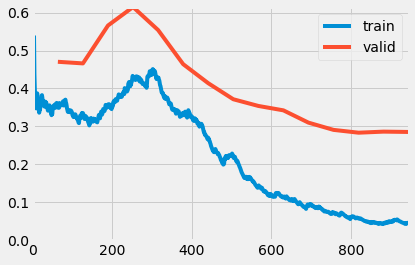

Better model found at epoch 1 with valid_loss value: 0.46611645817756653.
Better model found at epoch 5 with valid_loss value: 0.4641228914260864.
Better model found at epoch 6 with valid_loss value: 0.41397976875305176.
Better model found at epoch 7 with valid_loss value: 0.3716879189014435.
Better model found at epoch 8 with valid_loss value: 0.3540436923503876.
Better model found at epoch 9 with valid_loss value: 0.3424241542816162.
Better model found at epoch 10 with valid_loss value: 0.31006309390068054.
Better model found at epoch 11 with valid_loss value: 0.2909619212150574.
Better model found at epoch 12 with valid_loss value: 0.28355222940444946.


In [13]:
learn.fit_one_cycle(15, lr_max = slice(5e-5, 3e-4), cbs = [WandbCallback(n_preds = 10),
                                                           SaveModelCallback(fname = "../models/ce_unfrozen_model"), 
                                                           CSVLogger(fname = "../logs/ce_unfrozen_loss.csv"),
                                                           ShowGraphCallback()])

In [14]:
learn.export("../models/ce_final_model.pkl")

In [15]:
# Log the frozen and unfrozen runs logs to wandb
frozen_logs = pd.read_csv("../logs/ce_frozen_loss.csv")
table = wandb.Table(dataframe = frozen_logs)
wandb.run.log({"FrozenModelTrainingSummary": table})

unfrozen_logs = pd.read_csv("../logs/ce_unfrozen_loss.csv")
table = wandb.Table(dataframe = unfrozen_logs)
wandb.run.log({"UnfrozenModelTrainingSummary": table})